Geometry: NDBR50, Epoch [100/1000], Loss: 2813939.5000
Geometry: NDBR50, Epoch [200/1000], Loss: 1768200.0000
Geometry: NDBR50, Epoch [300/1000], Loss: 1089784.8750
Geometry: NDBR50, Epoch [400/1000], Loss: 668280.9375
Geometry: NDBR50, Epoch [500/1000], Loss: 419815.2188
Geometry: NDBR50, Epoch [600/1000], Loss: 280863.9688
Geometry: NDBR50, Epoch [700/1000], Loss: 206948.8438
Geometry: NDBR50, Epoch [800/1000], Loss: 169497.9375
Geometry: NDBR50, Epoch [900/1000], Loss: 151450.7500
Geometry: NDBR50, Epoch [1000/1000], Loss: 143212.5938
Geometry: NDBR20, Epoch [100/1000], Loss: 137904.9531
Geometry: NDBR20, Epoch [200/1000], Loss: 136404.7812
Geometry: NDBR20, Epoch [300/1000], Loss: 135850.9219
Geometry: NDBR20, Epoch [400/1000], Loss: 135660.8438
Geometry: NDBR20, Epoch [500/1000], Loss: 135599.7969
Geometry: NDBR20, Epoch [600/1000], Loss: 135580.8281
Geometry: NDBR20, Epoch [700/1000], Loss: 135574.4062
Geometry: NDBR20, Epoch [800/1000], Loss: 135571.3438
Geometry: NDBR20, Epoch 

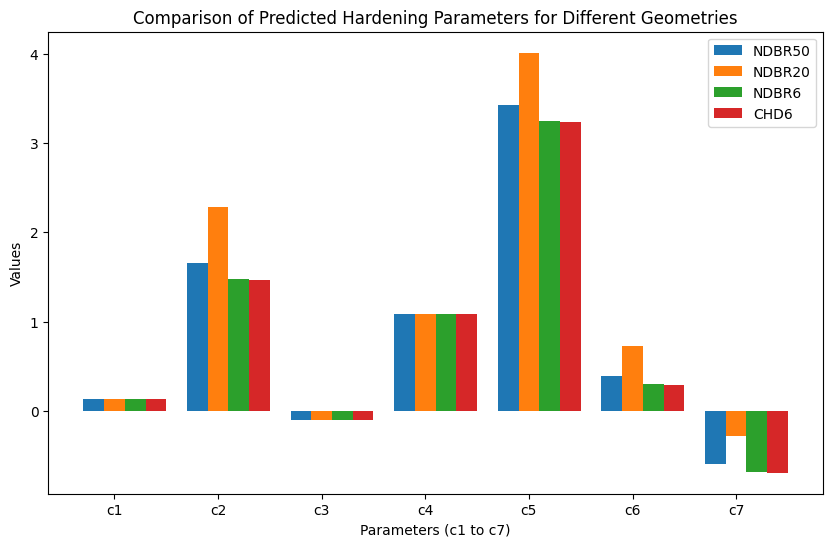

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
dataPoints = {'NDBR50': 50000, 'NDBR20': 50000, 'NDBR6': 50000, 'CHD6': 50000}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/NEWDATA/newData_NDBR50_FD.csv",
    'NDBR20': "MODEL_DATA/NEWDATA/newData_NDBR20_FD.csv",
    'NDBR6': "MODEL_DATA/NEWDATA/newData_NDBR6_FD.csv",
    'CHD6': "MODEL_DATA/NEWDATA/newData_CHD6_FD.csv"
}

Y_file = "MODEL_DATA/NEWDATA/newData_HardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

input_size = 2
output_size = 7  # Number of output dimensions (c1 to c7)

# Define a custom linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # Single linear layer

    def forward(self, x):
        x = self.fc(x)
        return x

# Create an instance of the linear regression model
model = LinearRegression(input_size, output_size)

# Define a loss function (custom MSE loss with regularization) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()  # Use standard mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

for geometry in geometries:
    num_samples = min(dataPoints[geometry], len(Y_data))
    X_sample = torch.tensor(X_data[geometry][:num_samples], dtype=torch.float32)
    Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained linear regression model
torch.save(model.state_dict(), 'trained_linear_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_linear_model.pth'))
model.eval()  # Set the model to evaluation mode

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)

plt.legend()
plt.show()
